Lets start by importing specific packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

## Common Time Series Patterns

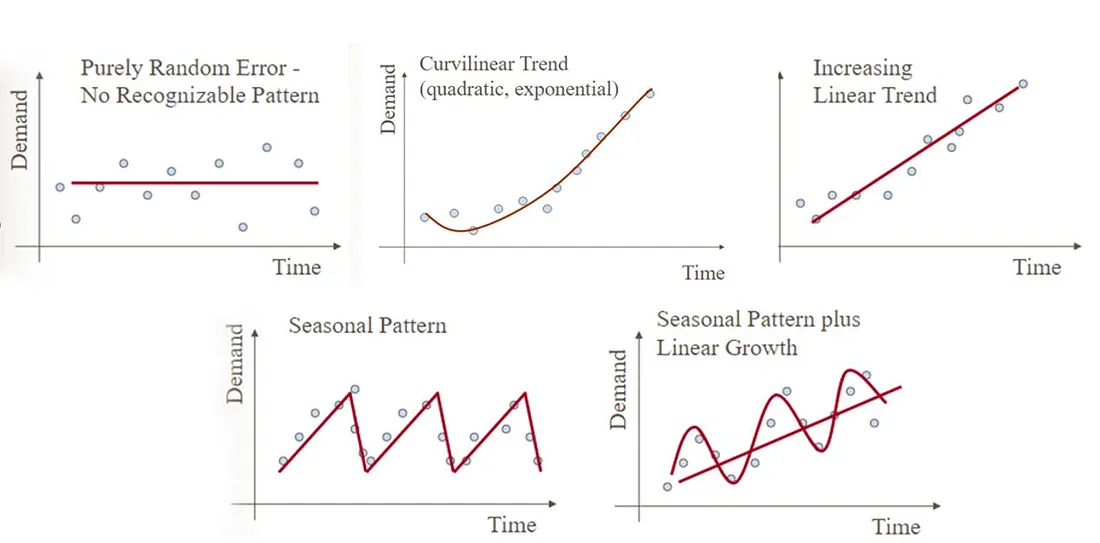
Reference: https://miro.medium.com/v2/resize:fit:1100/format:webp/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg

## Data Reading

In [2]:
df = pd.read_csv('./data/PJME_hourly.csv')
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [3]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


Lets visualize the data.

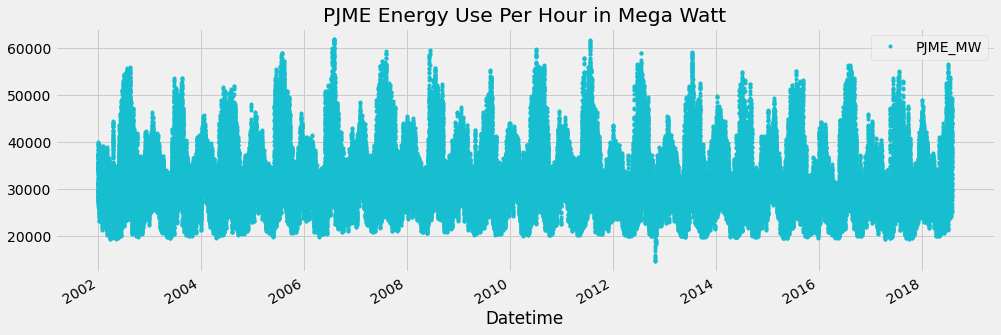

In [4]:
ax = df.plot(style='.', figsize=(15, 5), color=color_pal[-1], 
             title='PJME Energy Use Per Hour in Mega Watt')

## Train/Test Split
Lets use all the data before 2015 for training and the remaining for testing.

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >=  '01-01-2015']
train.shape, test.shape

((113926, 1), (31440, 1))

Lets visualize this using matplotlib.

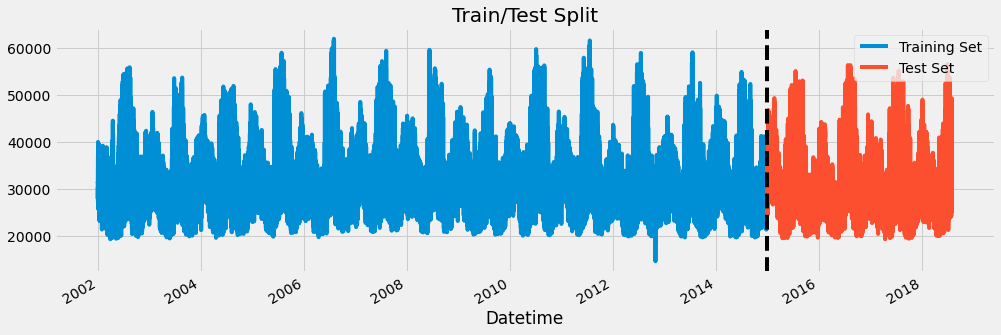

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title = 'Train/Test Split')
test.plot(ax=ax, label='Test Set')

# lets add a black line to separate the splits
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

Lets see what one week of Data looks like?

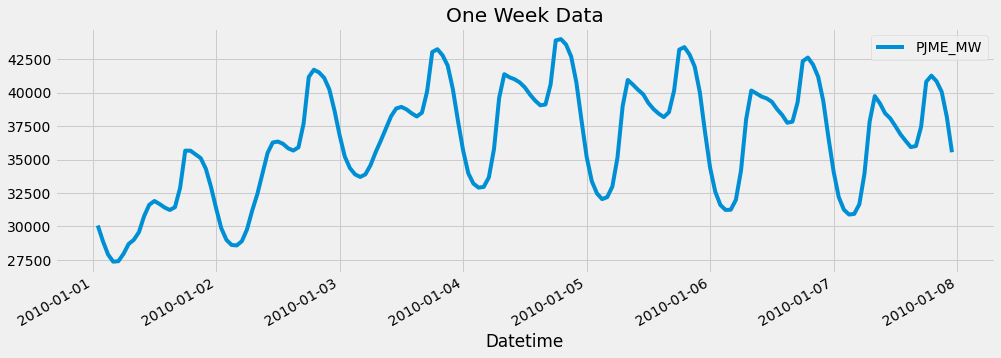

In [7]:
df.loc[(df.index > "01-01-2010") & (df.index < '01-08-2010')].plot(figsize=(15, 5),
                                                                  title='One Week Data')
plt.show()

## Feature Creation

As we are using DateTime as our index, we can create a few interesting features from DateTime

In [8]:
def create_features(df):
    """
    Create time series features based on time series index. 
    """
    df = df.copy()
    df['Hour'] = df.index.hour
    df['Day_Of_Week'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Day_Of_Year']=df.index.dayofyear
    df = df[['Hour', 'Day_Of_Week', 'Quarter', 'Month', 'Year', 'Day_Of_Year', 'PJME_MW']]
    return df
df = create_features(df)
df

,Hour,Day_Of_Week,Quarter,Month,Year,Day_Of_Year,PJME_MW
Datetime,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,24860.0
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,20,0,1,1,2018,1,44284.0
2018-01-01 21:00:00,21,0,1,1,2018,1,43751.0
2018-01-01 22:00:00,22,0,1,1,2018,1,42402.0


## Visualize Feature/Target Relationship

One way of Visualizing the relationship is to use sns.boxplot.

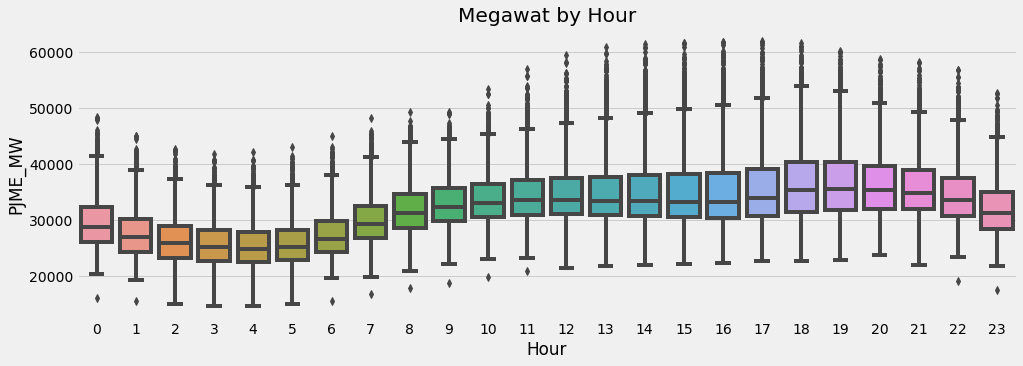

In [9]:
# starting with hour
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='Hour', y='PJME_MW')
ax.set_title("Megawat by Hour")
plt.show()


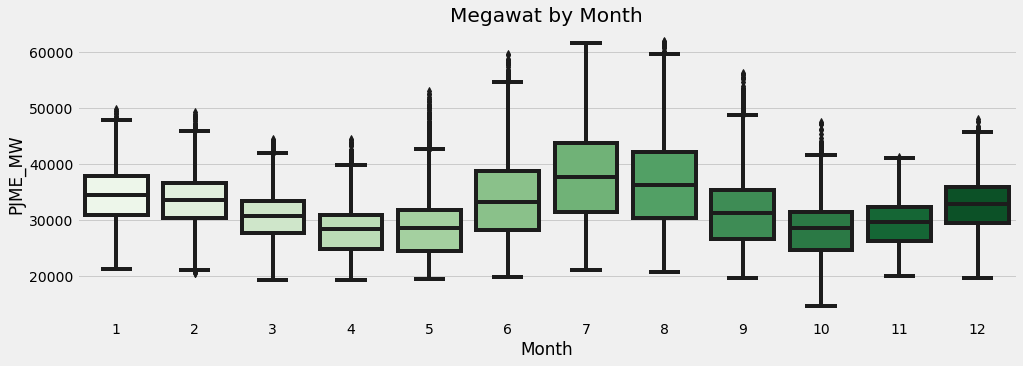

In [10]:
# Same with Month
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='Month', y='PJME_MW', palette='Greens')
ax.set_title("Megawat by Month")
plt.show()


## Model

This is a regression task, we will be using XGB Regressor Model

In [11]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 50,
                      learning_rate = 0.01)

Lets pass the training and testing data - Before that, lets pass it to our feature_creation 
function to create the features

In [12]:
train = create_features(train)
test = create_features(test)


In [13]:
# Lets define the features and target
Features = ['Hour', 'Day_Of_Week', 'Quarter', 'Month', 'Year', 'Day_Of_Year']
Target = ['PJME_MW']


Splitting the Data into X_train, Y_train, X_test, Y_test.

In [14]:
X_train = train[Features]
Y_train = train[Target]

X_test = test[Features]
Y_test = test[Target]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((113926, 6), (113926, 1), (31440, 6), (31440, 1))

Passing the Data to our Model

In [15]:
reg.fit(X_train, Y_train, 
       eval_set = [(X_train, Y_train), (X_test, Y_test)],
       verbose=100
       )

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.66004
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.30811
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.25476
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.04915
[437]	validation_0-rmse:2793.31200	validation_1-rmse:3727.16078


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

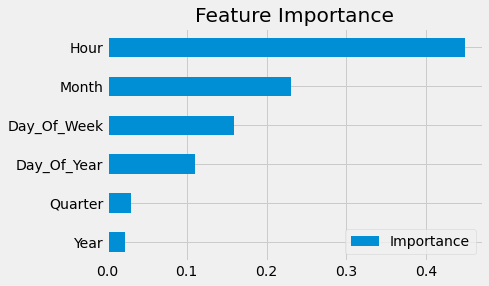

In [16]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_,
            columns = ['Importance'])
fi.sort_values("Importance",  ascending=True).plot(kind='barh',
                                                   title='Feature Importance')
plt.show()

## Forecast on Test Set

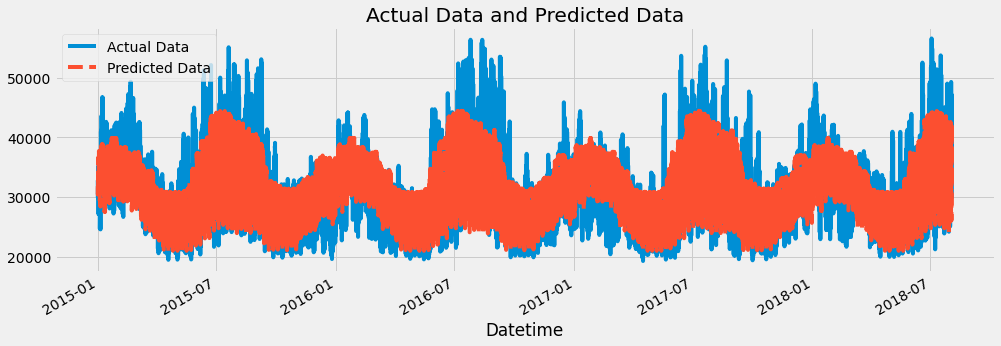

In [17]:
test['Prediction']=reg.predict(X_test)
ax = test['PJME_MW'].plot(figsize=(15, 5))
test['Prediction'].plot(ax=ax, style='--')
plt.legend(['Actual Data', 'Predicted Data'])
ax.set_title("Actual Data and Predicted Data")
plt.show()

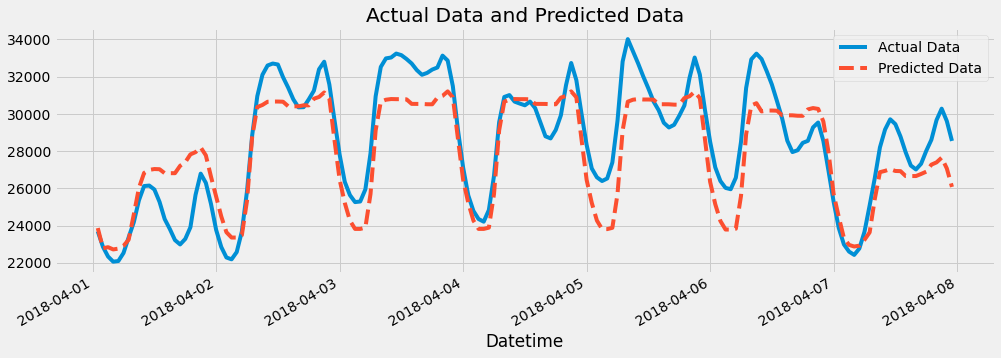

In [18]:
# lets plot the one week of data and predictions to understand it better
ax = test[(test.index > '04-01-2018') & (test.index < '04-08-2018')][['PJME_MW']].plot(figsize=(15, 5))
test[(test.index > '04-01-2018') & (test.index < '04-08-2018')][['Prediction']].plot(ax=ax, style='--')
plt.legend(['Actual Data', 'Predicted Data'])
ax.set_title("Actual Data and Predicted Data")
plt.show()

## Evaluation Metrics

In [19]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['Prediction']))
print(f"RMSE on test set: {score:0.2}")

RMSE on test set: 3.7e+03


We can also calculate the error by simply subtracting two columns


In [20]:
test['Error'] = np.abs(test['PJME_MW'] - test["Prediction"])

# Now that we have saved it in DataFrame, we can look at the best and worst predicted days
test['Date'] = test.index.date

# The worst predicted days
test.groupby('Date')['Error'].mean().sort_values(ascending=False).head(5)

# The best predicted days
test.groupby('Date')['Error'].mean().sort_values().head(5)

Date
2016-09-27    376.074544
2016-05-01    420.460286
2016-04-04    432.775065
2015-03-10    444.994792
2016-12-08    480.121663
Name: Error, dtype: float64